In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt

#arbitrarily choose images/cameras
chosenImages = [4,5,6,7,8,9,10]
numChosen = len(chosenImages)
end_camera = 50

# initialize filepaths
## later implement input for directory
cDIR = os.getcwd()
NDPath = cDIR + r'\NotreDame\NotreDame'
listFile = NDPath + '\list.txt'
outFile = NDPath + r'\notredame.out'

In [7]:
### Extract the camera parameters and point correspondences from the output file, `notredame.out`, from Bundler
camera_data = np.array([], dtype = float)
points_3d = np.empty([num_points,3], dtype = float)
points_3d_rgb = np.empty([num_points,3], dtype = int)
#     view_list = np.empty(num_points, dtype = float)
camera_index = np.array([], dtype = int)
point_index = np.array([], dtype = int)
xp = np.array([], dtype = float)
yp = np.array([], dtype = float)
total_num_views = 0

try:
    with open(outFile) as fp:
        line0 = fp.readline() #read line 0 (the title)
        num_cameras, num_points = map(int, fp.readline().strip('\n').split(' ')) #read line 1

    with open(outFile) as f:
        for i, line in enumerate(f):
            # extract camera parameters
            for i in range(end_camera):
                c = 5
                if len(camera_data) == 0:
                    camera_data = np.array(fp.readline().strip('\n').split(' '),dtype = float)
                    c = 4
                for j in range(c):
                    camera_data = np.vstack([camera_data,np.array(fp.readline().strip('\n').split(' '),dtype = float)]) #reads 5 lines         

            # extract point correspondences of outputted 3D points, starts reading on line 2+num_cameras*5
            for i in range(num_points):
                points_3d[i] = np.array(fp.readline().strip('\n').split(' '),dtype = float) #read 3D coordinates
                points_3d_rgb[i] = np.array(fp.readline().strip('\n').split(' '),dtype = int) #read RGB value
                line = np.array(fp.readline().strip('\n').split(' '),dtype = float) #read view list
                num_views = int(line[0])
                total_num_views += num_views
                for j in range(num_views):
                    cameraID = int(line[j*4+1])
                    x = line[j*4+3]
                    y = line[j*4+4]
                    camera_index = np.append(camera_index,cameraID)
                    point_index = np.append(point_index,i)
                    xp = np.append(xp,x)
                    yp = np.append(yp,y)
                
except:
    print('Data parsing unsuccessful. Check data file format')

if ((len(camera_index)==len(point_index)) and (len(point_index) == len(xp)) 
    and (len(xp)==len(yp)) and (len(yp)==total_num_views)):
    print('Data parsing successful')
else:
    print('Data parsing unsuccessful. Check data file format')

               
# for i in range(num_cameras):
#     camera = Camera()
#     camera.f = camera_data[i*5,0]
#     camera.k1 = camera_data[i*5,1]
#     camera.k2 = camera_data[i*5,2]
#     camera.R = camera_data[i*5+1:i*5+4] #
#     camera.t = camera_data[i*5+4]
#     cameras.append(camera)

Data parsing successful


In [8]:
print(len(camera_index))
print(len(point_index))
print(len(xp))
print(len(yp))
print(total_num_views)


748003
748003
748003
748003
748003


In [15]:
### Define functions

def project(point, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    # allocate camera parameters
    R = camera_params[1:4,:]
    t = camera_params[4]
    f,k1,k2 = camera_params[0]
    
    Q = np.matmul(R,np.transpose(point)) + np.transpose(t) #convert real world to camera coordinates
    q = -Q[0:1]/Q[2] #perspective division
    q2 = np.linalg.norm(q)
    p = f*(1+k1*q2+k2*q2*q2)*q #convert to pixel coordinates
    
    return p

x0 = np.hstack((camera_data.ravel(), points_3d.ravel()))
points_2d = np.transpose([xp,yp])

def batch_project(params, point_index, camera_index, total_num_views, num_cameras, num_points):
    camera_params = params[:num_cameras*5*3].reshape((num_cameras*5,3))
    points_3d = params[num_cameras*5*3:].reshape((num_points,3))
    point_proj = np.empty([total_num_views,2])
    for i in range(total_num_views):
        point_proj[i] = project(points_3d[point_index[i]],
                                                   camera_params[camera_index[i]*5:camera_index[i]*5+5,:])
    
    return point_proj

def collect_unique(points_3d, point_index, camera_data, camera_index, chosenImages):
    """ Collect only those cameras and 3D points from the full dataset that appear in the chosen image set"""
    unique_points = points_3d[list(set(point_index))]
    
    
def fun(params, point_index, camera_index, total_num_views, num_cameras, num_points, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    points_proj = batch_project(params, point_index, camera_index, total_num_views, num_cameras, num_points)
    
    return (points_proj - points_2d).ravel()

from scipy.sparse import lil_matrix

def sparseJacobian(num_cameras, num_points, camera_index, point_index, total_num_views):
    m = total_num_views * 2
    n = num_cameras * 3 * 5 + num_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(total_num_views)
    for s in range(3*5):
        A[2 * i, camera_index * 3*5 + s] = 1
        A[2 * i + 1, camera_index * 3*5 + s] = 1

    for s in range(3):
        A[2 * i, num_cameras * 3*5 + point_index * 3 + s] = 1
        A[2 * i + 1, num_cameras * 3*5 + point_index * 3 + s] = 1

    return A

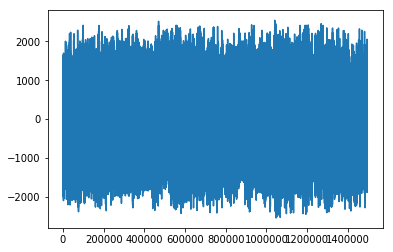

In [12]:
residuals = fun(x0, point_index, camera_index, total_num_views, num_cameras, num_points, points_2d)
plt.plot(residuals)


In [16]:
A = sparseJacobian(num_cameras, num_points, camera_index, point_index, total_num_views)
### Optimize (least squares)
import time
from scipy.optimize import least_squares
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(point_index, camera_index, total_num_views, num_cameras, num_points, points_2d))
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3914e+11                                    1.75e+10    
       1              4         1.2429e+11      1.48e+10       1.56e+03       1.39e+10    
       2              6         1.1836e+11      5.94e+09       7.40e+02       1.27e+10    
       3              7         1.0850e+11      9.85e+09       1.40e+03       1.09e+10    
       4              9         1.0441e+11      4.10e+09       6.61e+02       1.01e+10    
       5             10         9.7408e+10      7.00e+09       1.22e+03       8.75e+09    
       6             11         8.7104e+10      1.03e+10       2.07e+03       6.52e+09    
       7             13         8.3445e+10      3.66e+09       8.32e+02       5.59e+09    
       8             14         7.8273e+10      5.17e+09       1.40e+03       3.86e+09    
       9             16         7.6505e+10      1.77e+09       5.57e+02       4.35e+09    

393018

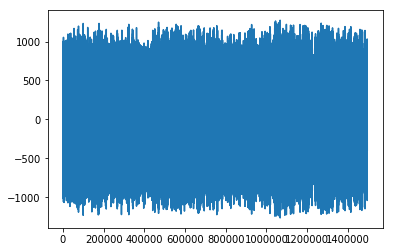

In [20]:
plt.plot(res.fun)
(17675/60)/60
res.x.size

In [ ]:
for i in range(len(res.x):
    x_3D = np.append(x_3D,points_3D[i+start_point_index,0])
    y_3D = np.append(y_3D,points_3D[i+start_point_index,1])
    z_3D = np.append(z_3D,points_3D[i+start_point_index,2])
    
# plot 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3D, y_3D, z_3D, c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()